In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Flatten, SpatialDropout2D, SpatialDropout1D, AlphaDropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use("ggplot")



If you get an error in the above cell, you may need to install some of these packages on your computer.

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions (Of the MNIST images)
img_rows, img_cols = 28, 28

Here we load the MNIST dataset. This dataset includes pictures of 70000 handwritten digits. It is a clasic dataset to use, when testing a neural network build for imgage classification. The data is divided into a testing and a training set. 

In [3]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

Let's check the data. How many datapoints in each catagory? 

In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

The below Neural Network model is set up to run with or without the dropout layer. We can use the dropout to calculate variance and probability of each classification later. If you want to employ a different way of estimating the confidence per classification, feel free to employ that instead. You are also welcome to improve this network. 

In [7]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)


def get_model(mc=False, act="relu"):
    inp = Input(input_shape)
    x = Conv2D(32, kernel_size=(3, 3), activation=act)(inp)
    x = Conv2D(64, kernel_size=(3, 3), activation=act)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = get_dropout(x, p=0.25, mc=mc)
    x = Flatten()(x)
    x = Dense(128, activation=act)(x)
    x = get_dropout(x, p=0.5, mc=mc)
    out = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inp, outputs=out)

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

Here we assign mc_model to the the dropout model. 

In [10]:
mc_model = get_model(mc=True, act="relu")

Run the model for 10 epochs. 

In [41]:
h_mc = mc_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 111s 236ms/step - loss: 2.1341 - accuracy: 0.3899 - val_loss: 2.0786 - val_accuracy: 0.4418
Epoch 2/10
469/469 [==============================] - 116s 247ms/step - loss: 2.0196 - accuracy: 0.4778 - val_loss: 1.9446 - val_accuracy: 0.5169
Epoch 3/10
469/469 [==============================] - 118s 253ms/step - loss: 1.8724 - accuracy: 0.5355 - val_loss: 1.7796 - val_accuracy: 0.5689
Epoch 4/10
469/469 [==============================] - 120s 256ms/step - loss: 1.6964 - accuracy: 0.5817 - val_loss: 1.5929 - val_accuracy: 0.6105
Epoch 5/10
469/469 [==============================] - 116s 248ms/step - loss: 1.5174 - accuracy: 0.6128 - val_loss: 1.4147 - val_accuracy: 0.6375
Epoch 6/10
469/469 [==============================] - 115s 246ms/step - loss: 1.3483 - accuracy: 0.6428 - val_loss: 1.2534 - val_accuracy: 0.6671
Epoch 7/10
469/469 [==============================] - 115s 246ms/step - loss: 1.2070 - accuracy: 0.6662 - val_loss: 1.1354 -

Here we use the dropout layer to calculate the predictions for each classification. This takes a while. You can set it to 500 if you are an impatiant person. 

In [114]:
import tqdm

mc_predictions = []
for i in tqdm.tqdm(range(1000)):
    y_p = mc_model.predict(x_test, batch_size=1000)
    mc_predictions.append(y_p)

100%|██████████| 1000/1000 [1:16:22<00:00,  4.58s/it]


Prediction variance 

In [43]:
max_vars = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    max_vars.append(px.std(axis=0)[px.mean(axis=0).argmax()])

Print the 100 classifications with the most variance 

In [44]:
(-np.array(max_vars)).argsort()[:100]

array([200, 186, 132,  48, 450, 222, 461, 201, 233, 172, 390, 449, 353,
       133, 120, 437, 315,  93, 347,  99, 162,  95, 400, 395, 412, 171,
       462, 469, 250, 293, 312, 128, 308, 214, 465, 356,  51, 343,  68,
       199, 209, 382, 351, 126, 291,  64,  58, 252, 371, 273, 380, 352,
       492, 326, 226, 328,  34, 179, 127,   3, 359, 451, 292, 259,  42,
       212,  28, 280, 281, 106, 220, 464, 405,   1, 453, 206, 197, 271,
       364,  75, 474, 102, 336, 248, 146, 221, 311, 493, 447, 232,   9,
       435, 495, 402, 446, 275, 277, 318, 362,  72], dtype=int64)

Here you can inspect the different classifications. Insert the numbers from the print above into the variable idx one at the time. Can you classify better in these insecure cases? 

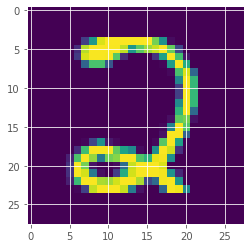

In [71]:
idx = 72
plt.imshow(x_test[idx][:,:,0])

The posterior mean is what the neural network estimated. True label is the absolute truth. The correct classification. 

posterior mean: 2
true label: 2

class: 0; probability: 14.3%; variance: 11.29% 
class: 1; probability: 0.6%; variance: 0.78% 
class: 2; probability: 49.3%; variance: 19.26% 
class: 3; probability: 25.1%; variance: 14.71% 
class: 4; probability: 0.8%; variance: 1.29% 
class: 5; probability: 1.6%; variance: 2.40% 
class: 6; probability: 1.5%; variance: 1.98% 
class: 7; probability: 1.6%; variance: 2.04% 
class: 8; probability: 5.0%; variance: 5.10% 
class: 9; probability: 0.2%; variance: 0.27% 


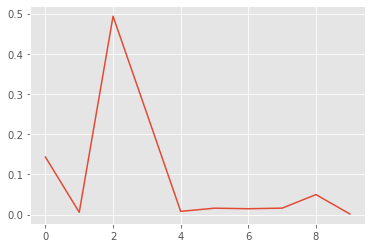

In [70]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()

# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; probability: {:.1%}; variance: {:.2%} ".format(i, prob, var))
    
#Plot the probability 
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

Here we do the same as above, but for the probability instead of the variance. This is baysian statistics, so probability refers to the predictive mean. 

In [55]:
max_means = []
preds = []
for idx in range(len(mc_predictions)):
    px = np.array([p[idx] for p in mc_predictions])
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())

In [61]:
(np.array(max_means)).argsort()[:100]

array([195, 191, 151,  96, 483, 456, 443, 346, 497, 211, 325, 478, 167,
        59,  53, 324, 268, 227, 241,   8, 498, 149,  78, 486,  97, 406,
       495, 193,  18,  92, 307,  46, 317,  11, 321, 301,  73,  38, 341,
       218, 184,  62, 420,  66,  33, 115, 289, 175, 429, 119, 433, 114,
       243, 182, 189, 319, 282, 266, 432, 159, 213, 403, 153, 144,  61,
       411, 110, 344, 340, 468,  84,  65, 338, 358, 457, 264, 394, 431,
       300, 316, 240, 299, 354, 277, 165,  45, 104, 397, 290,  63, 435,
       274, 304, 116, 367, 139, 244, 177,  15, 421], dtype=int64)

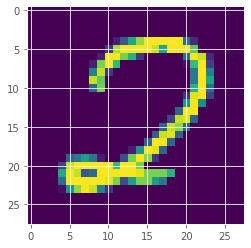

In [56]:
idx = 421
plt.imshow(x_test[idx][:,:,0])

posterior mean: 2
true label: 2

class: 0; probability: 28.7%; variance: 16.80% 
class: 1; probability: 0.9%; variance: 1.24% 
class: 2; probability: 33.9%; variance: 17.46% 
class: 3; probability: 11.6%; variance: 8.91% 
class: 4; probability: 0.9%; variance: 1.62% 
class: 5; probability: 7.5%; variance: 7.31% 
class: 6; probability: 2.5%; variance: 2.65% 
class: 7; probability: 2.3%; variance: 2.25% 
class: 8; probability: 11.4%; variance: 9.25% 
class: 9; probability: 0.2%; variance: 0.27% 


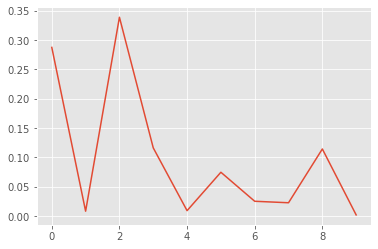

In [57]:
p0 = np.array([p[idx] for p in mc_predictions])
print("posterior mean: {}".format(p0.mean(axis=0).argmax()))
print("true label: {}".format(y_test[idx].argmax()))
print()
# probability + variance
for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
    print("class: {}; probability: {:.1%}; variance: {:.2%} ".format(i, prob, var))
    
#Plot the probability 
x, y = list(range(len(p0.mean(axis=0)))), p0.mean(axis=0)
plt.plot(x, y);

When you present the images to the human assistant, it is important that you do not also display the true label, as in the examples above. 

Part of the task is also to check if the human assistant improves the model. How can we calculate that? Here we can calculate how accurate the model is: 

In [110]:
accs = []
for y_p in mc_predictions:
    acc = accuracy_score(y_test.argmax(axis=1), y_p.argmax(axis=1))
    accs.append(acc)
print("MC accuracy: {:.1%}".format(sum(accs)/len(accs)))
print("Number of correct estimations:".format((sum(accs)))

print(sum(accs)) #Number of correct guessess (Does anyone know why this is a decimal? strange) 
print(accs) #Not out of 10.000, but 1000, that was the number we chose in tqdm above. 

MC accuracy: 73.6%
368.1625000000001
500


0.736